In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("/Users/paxton615/GA/resource-datasets/\
sacramento_real_estate/Sacramentorealestatetransactions.csv")
df.columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'price', 'latitude', 'longitude'],
      dtype='object')

In [13]:
df.describe()

,zip,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,95750.697462,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,85.176072,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,95660.000000,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,95762.000000,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,95828.000000,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


In [14]:
df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [15]:
df.type.unique()

array(['Residential', 'Condo', 'Multi-Family', 'Unkown'], dtype=object)

In [21]:
df.sale_date.unique()

array(['Wed May 21 00:00:00 EDT 2008', 'Tue May 20 00:00:00 EDT 2008',
       'Mon May 19 00:00:00 EDT 2008', 'Fri May 16 00:00:00 EDT 2008',
       'Thu May 15 00:00:00 EDT 2008'], dtype=object)

In [23]:
df.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

In [28]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);


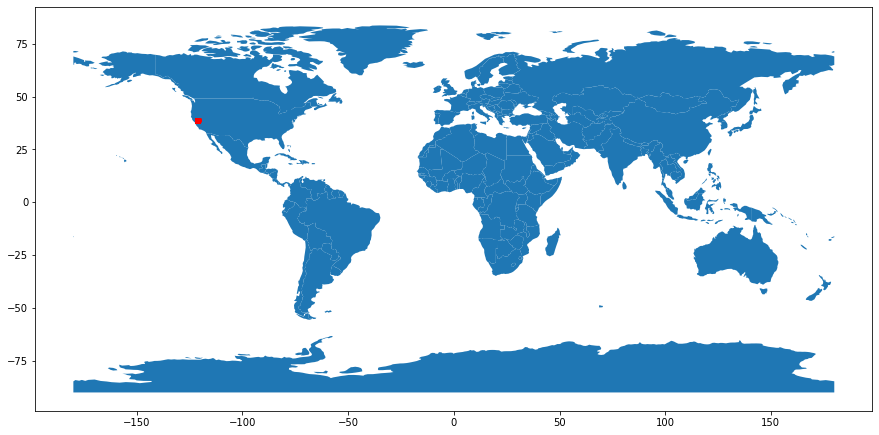

In [32]:
# df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15);


In [30]:
!pip install descartes

You should consider upgrading via the '/Users/paxton615/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
